In [1]:
# %% [code]
import os
import torch
import matplotlib.pyplot as plt
import imageio
import numpy as np

# Import necessary PyTorch3D components.
from pytorch3d.renderer import (
    FoVPerspectiveCameras,
    PointLights,
    look_at_view_transform,
)
import pytorch3d
from pytorch3d.structures import Meshes

from starter.utils import get_device, get_mesh_renderer, load_cow_mesh

In [5]:
# Set up the device (GPU if available, otherwise CPU)
device = get_device()
print("Using device:", device)

# Set image size for rendering.
image_size = 512

# Get the renderer.
renderer = get_mesh_renderer(image_size=image_size)

# Load the cow mesh (vertices and faces).
cow_obj_path = "data/cow.obj"  # Adjust path as needed.
vertices, faces = load_cow_mesh(cow_obj_path)
vertices = vertices.unsqueeze(0)  # Make it (1, N_v, 3)
faces = faces.unsqueeze(0)  # Make it (1, N_f, 3)

# Create per-vertex textures.
# We set a base color here; adjust if desired.
base_color = torch.tensor([0.7, 0.7, 1.0], device=device)
textures = torch.ones_like(vertices, device=device) * base_color

# Construct the mesh.
mesh = pytorch3d.structures.Meshes(
    verts=vertices.to(device),
    faces=faces.to(device),
    textures=pytorch3d.renderer.TexturesVertex(textures),
)

# Create a list to hold all rendered images.
rendered_images = []

# Define light source: here, we keep the light fixed.
lights = PointLights(location=[[0, 0, -3]], device=device)

# Set the distance and elevation for the camera.
distance = 3.0  # Distance from the object.
elevation = 10.0  # A small elevation to avoid a perfectly horizontal view.

# Number of frames (adjust for smoother/faster rotation)
num_frames = 36

# Loop over a full 360-degree rotation.
for i, azimuth in enumerate(np.linspace(0, 360, num_frames, endpoint=False)):
    # Get the camera rotation (R) and translation (T) using look_at_view_transform.
    R, T = look_at_view_transform(
        dist=distance, elev=elevation, azim=azimuth, device=device
    )

    # Create a camera with the computed R and T.
    cameras = FoVPerspectiveCameras(R=R, T=T, fov=60, device=device)

    # Render the image. The output has shape (B, H, W, 4), where the last channel is the alpha/silhouette.
    rend = renderer(mesh, cameras=cameras, lights=lights)

    # Convert to CPU numpy array and drop the alpha channel.
    image = rend[0, ..., :3].cpu().numpy()

    # Append image to the list.
    rendered_images.append((255 * image).astype(np.uint8))

    # Optionally, display progress.
    print(f"Rendered frame {i+1}/{num_frames} with azimuth {azimuth:.1f}°")

# Save the list of images as a GIF.
gif_path = "images/cow_turntable.gif"
duration_ms = 1000 // 15  # duration in ms per frame (15 FPS)

imageio.mimsave(gif_path, rendered_images, duration=duration_ms / 1000, loop=0)
print(f"Saved 360-degree render GIF to {gif_path}")

Using device: cuda:0
Rendered frame 1/36 with azimuth 0.0°
Rendered frame 2/36 with azimuth 10.0°
Rendered frame 3/36 with azimuth 20.0°
Rendered frame 4/36 with azimuth 30.0°
Rendered frame 5/36 with azimuth 40.0°
Rendered frame 6/36 with azimuth 50.0°
Rendered frame 7/36 with azimuth 60.0°
Rendered frame 8/36 with azimuth 70.0°
Rendered frame 9/36 with azimuth 80.0°
Rendered frame 10/36 with azimuth 90.0°
Rendered frame 11/36 with azimuth 100.0°
Rendered frame 12/36 with azimuth 110.0°
Rendered frame 13/36 with azimuth 120.0°
Rendered frame 14/36 with azimuth 130.0°
Rendered frame 15/36 with azimuth 140.0°
Rendered frame 16/36 with azimuth 150.0°
Rendered frame 17/36 with azimuth 160.0°
Rendered frame 18/36 with azimuth 170.0°
Rendered frame 19/36 with azimuth 180.0°
Rendered frame 20/36 with azimuth 190.0°
Rendered frame 21/36 with azimuth 200.0°
Rendered frame 22/36 with azimuth 210.0°
Rendered frame 23/36 with azimuth 220.0°
Rendered frame 24/36 with azimuth 230.0°
Rendered frame 

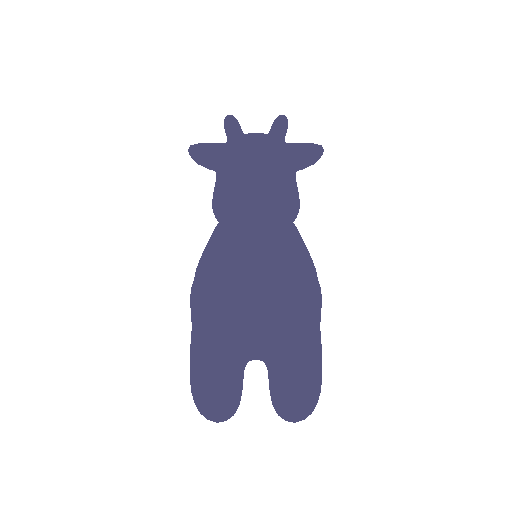

In [6]:
try:
    from IPython.display import Image as IPImage, display

    display(IPImage(filename=gif_path))
except Exception as e:
    print("Unable to display GIF inline:", e)

In [13]:
# Setup device and renderer.
device = get_device()
image_size = 512
renderer = get_mesh_renderer(image_size=image_size, device=device)

vertices = torch.tensor(
    [
        [1.0, 1.0, 1.0],  # v0
        [1.0, -1.0, -1.0],  # v1
        [-1.0, 1.0, -1.0],  # v2
        [-1.0, -1.0, 1.0],  # v3
    ],
    dtype=torch.float32,
    device=device,
)

# Define 4 faces (each face is a triangle specified by the indices of 3 vertices).
faces = torch.tensor(
    [
        [0, 1, 2],  # Face 1: vertices v0, v1, v2
        [0, 3, 1],  # Face 2: vertices v0, v3, v1
        [0, 2, 3],  # Face 3: vertices v0, v2, v3
        [1, 3, 2],  # Face 4: vertices v1, v3, v2 (the base)
    ],
    dtype=torch.int64,
    device=device,
)

# Create a per-vertex texture. Here we use a uniform color.
# The texture tensor should have shape (N_vertices, 3). We multiply by a color.
base_color = torch.tensor([1.0, 0.5, 0.5], device=device)  # light reddish color
textures = torch.ones_like(vertices, device=device) * base_color

# Create the mesh. Note: Meshes in PyTorch3D expect batched inputs.
tetra_mesh = Meshes(
    verts=[vertices],  # list of (N_v x 3) tensors
    faces=[faces],  # list of (N_f x 3) tensors
    textures=pytorch3d.renderer.TexturesVertex(
        textures.unsqueeze(0)
    ),  # add batch dimension
)

# Set up a fixed light (the same as in earlier examples).
lights = PointLights(location=[[0, 0, -3]], device=device)

# Create a 360-degree rotation by rendering from multiple azimuth angles.
num_frames = 36  # Adjust for smoother rotation if desired.
rendered_images = []

# Loop over azimuth angles from 0 to 360 degrees.
for azimuth in np.linspace(0, 360, num_frames, endpoint=False):
    # Use a fixed distance and elevation; adjust as needed.
    distance = 3.0
    elevation = 30.0
    R, T = look_at_view_transform(
        dist=distance, elev=elevation, azim=azimuth, device=device
    )

    # Create a camera with the current parameters.
    cameras = FoVPerspectiveCameras(R=R, T=T, fov=60, device=device)

    # Render the tetrahedron.
    rend = renderer(tetra_mesh, cameras=cameras, lights=lights)
    image = rend[0, ..., :3].cpu().numpy()  # Drop the alpha channel.
    rendered_images.append((255 * image).astype(np.uint8))

# Save the rendered frames as a GIF.
gif_path = "images/tetrahedron_turntable.gif"
duration_per_frame = 1000 / 15  # 15 frames per second, in ms per frame.
imageio.mimsave(gif_path, rendered_images, duration=duration_per_frame / 1000, loop=0)
print("Saved tetrahedron 360-degree GIF to:", gif_path)

Saved tetrahedron 360-degree GIF to: images/tetrahedron_turntable.gif


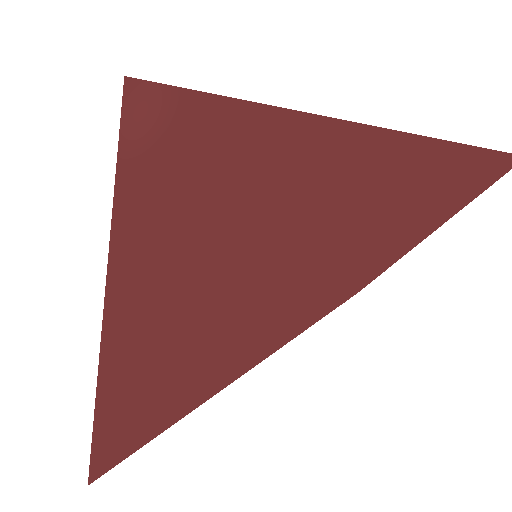

In [14]:
# Optionally, display the GIF inline (for Jupyter Notebook).
try:
    from IPython.display import Image as IPImage, display

    display(IPImage(filename=gif_path))
except Exception as e:
    print("Unable to display GIF inline:", e)

In [17]:
# Set up the device and renderer.
device = get_device()
image_size = 512
renderer = get_mesh_renderer(image_size=image_size, device=device)

# Define the 8 vertices of the cube.
# A cube centered at the origin with side length 2.
vertices = torch.tensor(
    [
        [-1.0, -1.0, -1.0],  # 0
        [1.0, -1.0, -1.0],  # 1
        [1.0, 1.0, -1.0],  # 2
        [-1.0, 1.0, -1.0],  # 3
        [-1.0, -1.0, 1.0],  # 4
        [1.0, -1.0, 1.0],  # 5
        [1.0, 1.0, 1.0],  # 6
        [-1.0, 1.0, 1.0],  # 7
    ],
    dtype=torch.float32,
    device=device,
)

# Define the 12 triangular faces.
# Each face of the cube is split into two triangles.
faces = torch.tensor(
    [
        # Bottom face (z = -1)
        [0, 1, 2],
        [0, 2, 3],
        # Top face (z = +1)
        [4, 6, 5],
        [4, 7, 6],
        # Front face (y = -1)
        [0, 4, 5],
        [0, 5, 1],
        # Right face (x = +1)
        [1, 5, 6],
        [1, 6, 2],
        # Back face (y = +1)
        [2, 6, 7],
        [2, 7, 3],
        # Left face (x = -1)
        [3, 7, 4],
        [3, 4, 0],
    ],
    dtype=torch.int64,
    device=device,
)

# Create a uniform per-vertex texture (e.g., a light green color).
base_color = torch.tensor([0.6, 1.0, 0.6], device=device)  # RGB values between 0 and 1
textures = torch.ones_like(vertices, device=device) * base_color

# Create the mesh. Meshes in PyTorch3D expect batched inputs.
cube_mesh = Meshes(
    verts=[vertices],
    faces=[faces],
    textures=pytorch3d.renderer.TexturesVertex(
        textures.unsqueeze(0)
    ),  # add batch dimension
)

# Set up a fixed light.
lights = PointLights(location=[[0, 0, -3]], device=device)

# Render the cube from multiple viewpoints to create a 360-degree animation.
num_frames = 36  # Adjust for smoother rotation if desired.
rendered_images = []

for azimuth in np.linspace(0, 360, num_frames, endpoint=False):
    # Use a fixed distance and elevation; adjust these parameters for a good framing.
    distance = 5.0
    elevation = 30.0
    R, T = look_at_view_transform(
        dist=distance, elev=elevation, azim=azimuth, device=device
    )
    cameras = FoVPerspectiveCameras(R=R, T=T, fov=60, device=device)

    # Render the cube.
    rend = renderer(cube_mesh, cameras=cameras, lights=lights)
    image = rend[0, ..., :3].cpu().numpy()  # Drop the alpha channel.
    rendered_images.append((255 * image).astype(np.uint8))

# Save the rendered frames as a GIF.
gif_path = "images/cube_turntable.gif"
duration_per_frame = 1000 / 15  # 15 frames per second, in ms per frame.
imageio.mimsave(gif_path, rendered_images, duration=duration_per_frame / 1000, loop=0)
print("Saved cube 360-degree GIF to:", gif_path)

Saved cube 360-degree GIF to: images/cube_turntable.gif


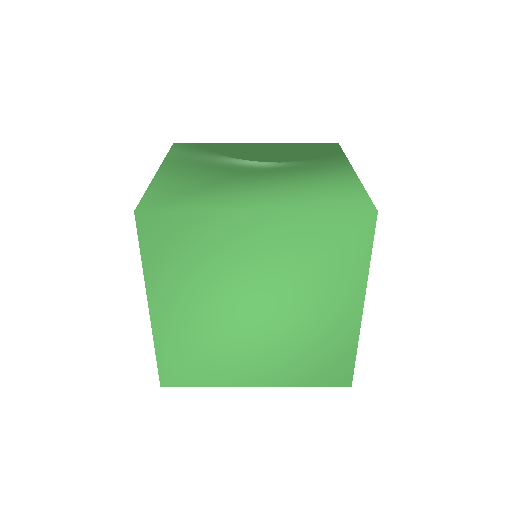

In [18]:
try:
    from IPython.display import Image as IPImage, display

    display(IPImage(filename=gif_path))
except Exception as e:
    print("Unable to display GIF inline:", e)

In [21]:
# %% [code]
# Load the cow mesh.
# The function load_cow_mesh returns vertices (N x 3) and faces (F x 3).
vertices, faces = load_cow_mesh("data/cow.obj")

vertices = vertices.to(device)
faces = faces.to(device)

# Compute the minimum and maximum z-coordinates.
# (The "front" of the cow is where z is smallest, and the "back" where z is largest.)
z_coords = vertices[:, 2]
z_min = z_coords.min()
z_max = z_coords.max()

# Define the two colors (as floats in [0,1]).
# color1: blue for the front; color2: red for the back.
color1 = torch.tensor(
    [0.0, 0.0, 1.0], device=device, dtype=torch.float32
)  # front: blue
color2 = torch.tensor([1.0, 0.0, 0.0], device=device, dtype=torch.float32)  # back: red

# Compute a per-vertex interpolation factor alpha.
# Reshape alpha to (N, 1) for proper broadcasting.
alpha = ((z_coords - z_min) / (z_max - z_min)).unsqueeze(1)

# Compute the per-vertex colors using linear interpolation.
# When alpha is 0 (front), the color is color1; when alpha is 1 (back), it is color2.
vertex_colors = (1 - alpha) * color1 + alpha * color2

# (Optional) Inspect the range of z values and a sample of the computed colors.
print("z_min:", z_min.item(), "z_max:", z_max.item())
print("Sample vertex color:", vertex_colors[0].cpu().numpy())

# Prepare the mesh:
# Add a batch dimension to vertices and faces.
vertices_batch = vertices.unsqueeze(0)  # Shape: (1, N, 3)
faces_batch = faces.unsqueeze(0)  # Shape: (1, F, 3)
# The per-vertex texture must also be batched, so add a batch dimension.
textures = vertex_colors.unsqueeze(0)  # Shape: (1, N, 3)

# Create the mesh using per-vertex textures.
cow_mesh = pytorch3d.structures.Meshes(
    verts=vertices_batch.to(device),
    faces=faces_batch.to(device),
    textures=pytorch3d.renderer.TexturesVertex(textures.to(device)),
)

# Set up the renderer (using the helper function from earlier).
# You can adjust the image size if desired.
image_size = 512
renderer = get_mesh_renderer(image_size=image_size, device=device)

# Set up a fixed light for the rendering.
lights = pytorch3d.renderer.PointLights(location=[[0, 0, -3]], device=device)

# Create a 360-degree turntable animation for the retextured cow.
num_frames = 36  # Number of frames for a smooth rotation.
rendered_images = []

for azimuth in np.linspace(0, 360, num_frames, endpoint=False):
    distance = 3.0  # Distance of the camera from the object.
    elevation = 30.0  # Elevation angle in degrees.

    # Compute the camera's rotation and translation.
    R, T = look_at_view_transform(
        dist=distance, elev=elevation, azim=azimuth, device=device
    )
    cameras = pytorch3d.renderer.FoVPerspectiveCameras(R=R, T=T, fov=60, device=device)

    # Render the mesh.
    rend = renderer(cow_mesh, cameras=cameras, lights=lights)
    image = rend[0, ..., :3].cpu().numpy()  # Drop the alpha channel.
    rendered_images.append((255 * image).astype(np.uint8))

# Save the rendered frames as a GIF.
gif_path = "images/cow_retextured_turntable.gif"
duration_per_frame = 1000 / 15  # Duration per frame (in ms) for 15 FPS.
imageio.mimsave(gif_path, rendered_images, duration=duration_per_frame / 1000, loop=0)
print("Saved retextured cow GIF to:", gif_path)

z_min: -0.6689090132713318 z_max: 1.0490000247955322
Sample vertex color: [0.3409237  0.         0.65907633]
Saved retextured cow GIF to: images/cow_retextured_turntable.gif


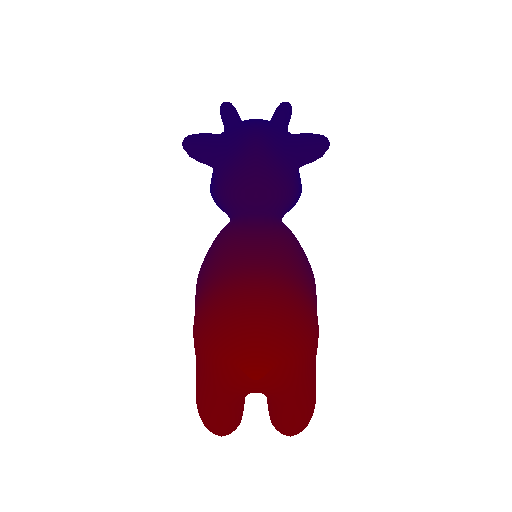

In [22]:
try:
    from IPython.display import Image as IPImage, display

    display(IPImage(filename=gif_path))
except Exception as e:
    print("Unable to display GIF inline:", e)

In [24]:
def render_textured_cow(
    cow_path="data/cow.obj",
    image_size=256,
    R_relative=[[1, 0, 0], [0, 1, 0], [0, 0, 1]],
    T_relative=[0, 0, 0],
    device=None,
):
    if device is None:
        device = get_device()
    meshes = pytorch3d.io.load_objs_as_meshes([cow_path]).to(device)
    R_relative = torch.tensor(R_relative).float()
    T_relative = torch.tensor(T_relative).float()
    R = R_relative @ torch.tensor([[1.0, 0, 0], [0, 1, 0], [0, 0, 1]])
    T = R_relative @ torch.tensor([0.0, 0, 3]) + T_relative
    renderer = get_mesh_renderer(image_size=256)
    cameras = pytorch3d.renderer.FoVPerspectiveCameras(
        R=R.unsqueeze(0),
        T=T.unsqueeze(0),
        device=device,
    )
    lights = pytorch3d.renderer.PointLights(
        location=[[0, 0.0, -3.0]],
        device=device,
    )
    rend = renderer(meshes, cameras=cameras, lights=lights)
    return rend[0, ..., :3].cpu().numpy()

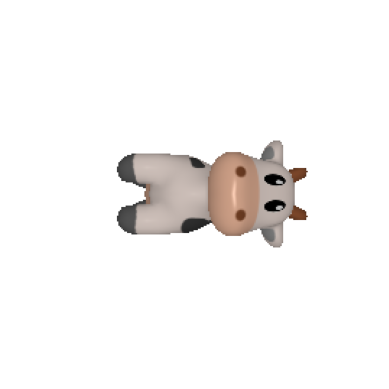

In [39]:
plt.imshow(render_textured_cow(R_relative=[[0, 1, 0], [-1, 0, 0], [0, 0, 1]]))
plt.axis("off")
plt.imsave(
    "images/cow_R_right.jpg",
    render_textured_cow(R_relative=[[0, 1, 0], [-1, 0, 0], [0, 0, 1]]),
)

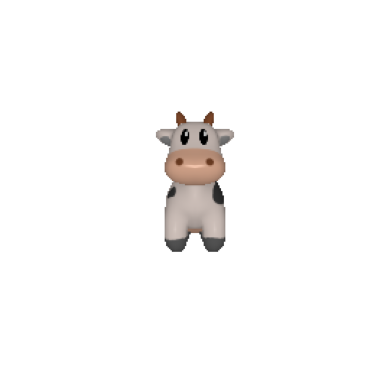

In [38]:
plt.imshow(render_textured_cow(T_relative=[0, 0, 1]))
plt.axis("off")
plt.imsave("images/cow_T_far.jpg", render_textured_cow(T_relative=[0, 0, 1]))

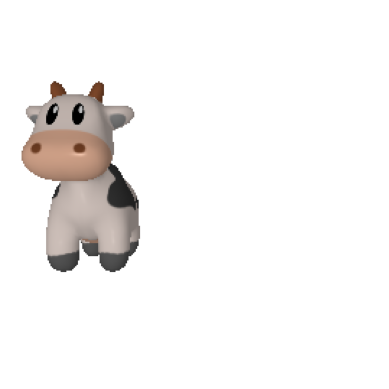

In [42]:
plt.imshow(render_textured_cow(T_relative=[1, 0, 0]))
plt.axis("off")
plt.imsave("images/cow_T_left.jpg", render_textured_cow(T_relative=[1, 0, 0]))

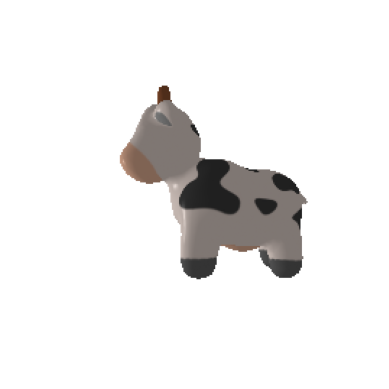

In [65]:
plt.imshow(
    render_textured_cow(
        R_relative=[[0, 0, 1], [0, 1, 0], [-1, 0, 0]], T_relative=[-3, 0, 3]
    )
)
plt.axis("off")
plt.imsave(
    "images/cow_composite.jpg",
    render_textured_cow(
        R_relative=[[0, 0, 1], [0, 1, 0], [-1, 0, 0]], T_relative=[-3, 0, 3]
    ),
)

In [2]:
from starter.render_generic import load_rgbd_data
from starter.utils import unproject_depth_image, get_points_renderer

In [3]:
# --- Load the RGB-D data ---
# Assume the pickle file has keys:
# "rgb0", "depth0", "mask0", "camera0", and similarly for the second image.
data = load_rgbd_data("data/rgbd_data.pkl")
device = get_device()

In [16]:
# --- Load the RGB-D data ---
# Assume the pickle file (e.g., "data/rgbd_data.pkl") contains keys:
# "rgb1", "depth1", "mask1", "camera1", and similarly "rgb2", "depth2", "mask2", "camera2".
data = load_rgbd_data("data/rgbd_data.pkl")
device = get_device()

# For the first image:
rgb1 = (
    torch.tensor(data["rgb1"]).float().to(device)
)  # shape: (S, S, 3), values in [0,1]
depth1 = torch.tensor(data["depth1"]).float().to(device)  # shape: (S, S)
mask1 = torch.tensor(data["mask1"]).float().to(device)  # shape: (S, S), binary
cam1 = data["cameras1"].to(device)

# For the second image:
rgb2 = torch.tensor(data["rgb2"]).float().to(device)
depth2 = torch.tensor(data["depth2"]).float().to(device)
mask2 = torch.tensor(data["mask2"]).float().to(device)
cam2 = data["cameras2"].to(device)

# --- Unproject each RGB-D image into a point cloud ---
points1, colors1 = unproject_depth_image(rgb1, mask1, depth1, cam1)
points2, colors2 = unproject_depth_image(rgb2, mask2, depth2, cam2)

# Create the union of the two point clouds.
points_union = torch.cat([points1, points2], dim=0)
colors_union = torch.cat([colors1, colors2], dim=0)

# --- Construct PyTorch3D PointCloud objects ---
import pytorch3d.structures as structures

# Each point cloud must be batched: shape (1, N, 3) and features (1, N, 4)
pc1 = structures.Pointclouds(points=[points1], features=[colors1])
pc2 = structures.Pointclouds(points=[points2], features=[colors2])
pc_union = structures.Pointclouds(points=[points_union], features=[colors_union])

# --- Set up the points renderer ---
# We assume get_points_renderer is defined in starter.utils.
points_renderer = get_points_renderer(image_size=256, radius=0.01)

# --- Define a function to render a given point cloud from a given camera viewpoint ---
from pytorch3d.renderer import FoVPerspectiveCameras, look_at_view_transform


def render_point_cloud(point_cloud, distance=6.0, elev=20.0, azim=0.0):
    """
    Render a point cloud using a camera at the specified spherical coordinates.
    """
    R, T = look_at_view_transform(dist=distance, elev=elev, azim=azim, device=device)
    cameras = FoVPerspectiveCameras(R=R, T=T, device=device)
    rend = points_renderer(point_cloud, cameras=cameras)
    # rend: (B, H, W, 4); drop the alpha channel and return uint8 image.
    image = rend[0, ..., :3].cpu().numpy()
    return (255 * image).astype(np.uint8)


# --- Create rotating views and compose side-by-side frames ---
num_frames = 36  # For a full 360° rotation
azimuths = np.linspace(0, 360, num_frames, endpoint=False)
frames = []

for az in azimuths:
    img1 = render_point_cloud(pc1, distance=6.0, elev=20.0, azim=az)
    img2 = render_point_cloud(pc2, distance=6.0, elev=20.0, azim=az)
    img_union = render_point_cloud(pc_union, distance=6.0, elev=20.0, azim=az)
    img1, img2, img_union = np.flipud(img1), np.flipud(img2), np.flipud(img_union)
    # Stack the three renderings horizontally.
    combined = np.concatenate([img1, img2, img_union], axis=1)
    frames.append(combined)

# --- Save the final GIF ---
gif_path = "images/rgbd_pointclouds_side_by_side.gif"
# For a frame rate of 15 FPS, the duration per frame in seconds is:
duration_sec = 1 / 15.0
imageio.mimsave(gif_path, frames, duration=duration_sec, loop=0)
print("Saved side-by-side GIF of point clouds to:", gif_path)

Saved side-by-side GIF of point clouds to: images/rgbd_pointclouds_side_by_side.gif


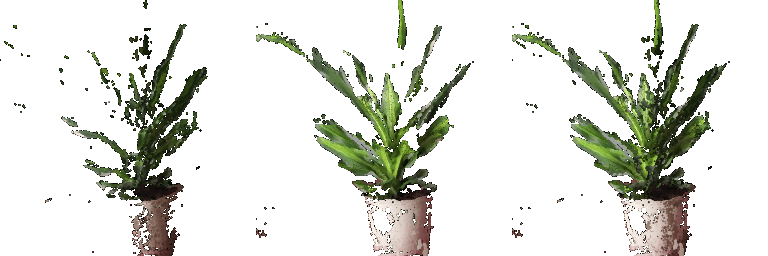

In [9]:
try:
    from IPython.display import Image as IPImage, display

    display(IPImage(filename=gif_path))
except Exception as e:
    print("Could not display GIF inline:", e)

In [17]:
# -----------------------------------------------
# 1. Generate a Torus Point Cloud (Parametric Function)
# -----------------------------------------------
def generate_torus(num_samples=200, R_major=1.0, r_minor=0.3, device=device):
    # Sample phi and theta uniformly in [0, 2*pi]
    phi = torch.linspace(0, 2 * np.pi, num_samples, device=device)
    theta = torch.linspace(0, 2 * np.pi, num_samples, device=device)
    Phi, Theta = torch.meshgrid(phi, theta, indexing="ij")
    # Parameterization of torus
    x = (R_major + r_minor * torch.cos(Theta)) * torch.cos(Phi)
    y = (R_major + r_minor * torch.cos(Theta)) * torch.sin(Phi)
    z = r_minor * torch.sin(Theta)
    points = torch.stack([x.flatten(), y.flatten(), z.flatten()], dim=1)
    # For a simple color, normalize coordinates to [0,1]
    colors = (points - points.min()) / (points.max() - points.min())
    # Optionally, you can tweak colors (e.g., assign a constant color or a gradient).
    return points, colors

In [18]:
# -----------------------------------------------
# 2. Generate a Mobius Strip Point Cloud (New Object)
# -----------------------------------------------
def generate_mobius(num_samples=200, device=device):
    u = torch.linspace(0, 2 * np.pi, num_samples, device=device)
    v = torch.linspace(-0.5, 0.5, num_samples, device=device)
    U, V = torch.meshgrid(u, v, indexing="ij")
    # Parameterization for a Mobius strip:
    x = (1 + (V / 2) * torch.cos(U / 2)) * torch.cos(U)
    y = (1 + (V / 2) * torch.cos(U / 2)) * torch.sin(U)
    z = (V / 2) * torch.sin(U / 2)
    points = torch.stack([x.flatten(), y.flatten(), z.flatten()], dim=1)
    colors = (points - points.min()) / (points.max() - points.min())
    return points, colors

In [26]:
# -----------------------------------------------
# 3. Utility: Render a Point Cloud from Parametric Points
# -----------------------------------------------
def render_point_cloud(
    points, colors, image_size=256, distance=4.0, elev=20.0, azim=0.0
):
    """
    Given a set of points and colors, create a point cloud and render from a camera.
    """
    pc = structures.Pointclouds(points=[points], features=[colors])
    R, T = look_at_view_transform(dist=distance, elev=elev, azim=azim, device=device)
    cameras = FoVPerspectiveCameras(R=R, T=T, device=device)
    rend = points_renderer(pc, cameras=cameras)
    # rend has shape (B, H, W, 4); we drop the alpha channel.
    image = rend[0, ..., :3].cpu().numpy()
    return (255 * image).astype(np.uint8)

In [29]:
# -----------------------------------------------
# 4. Create a 360° Rotation GIF for a Given Parametric Object
# -----------------------------------------------
def create_rotation_gif(
    points, colors, gif_path, num_frames=36, distance=4.0, elev=20.0, image_size=256
):
    frames = []
    azimuths = np.linspace(0, 360, num_frames, endpoint=False)
    for az in azimuths:
        img = render_point_cloud(
            points, colors, image_size=image_size, distance=distance, elev=elev, azim=az
        )
        frames.append(img)
    imageio.mimsave(gif_path, frames, duration=1 / 15, loop=0)
    print("Saved GIF to:", gif_path)
    return gif_path

In [30]:
# -----------------------------------------------
# 5. Generate and Render the Torus
# -----------------------------------------------
torus_points, torus_colors = generate_torus(
    num_samples=200, R_major=1.0, r_minor=0.3, device=device
)

torus_gif = create_rotation_gif(
    torus_points,
    torus_colors,
    gif_path="images/torus_rotation.gif",
    num_frames=36,
    distance=4.0,
    elev=20.0,
)

Saved GIF to: images/torus_rotation.gif


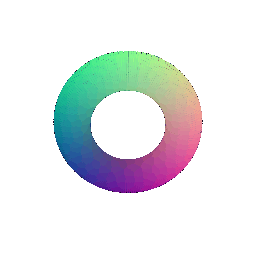

In [32]:
try:
    from IPython.display import Image as IPImage, display

    display(IPImage(filename="images/torus_rotation.gif"))
except Exception as e:
    print("Could not display GIF inline:", e)

In [ ]:
# -----------------------------------------------
# 6. Generate and Render the Mobius Strip (New Object)
# -----------------------------------------------
mobius_points, mobius_colors = generate_mobius(num_samples=200, device=device)

mobius_gif = create_rotation_gif(
    mobius_points,
    mobius_colors,
    gif_path="images/mobius_rotation.gif",
    num_frames=36,
    distance=4.0,
    elev=20.0,
)

Saved GIF to: images/mobius_rotation.gif


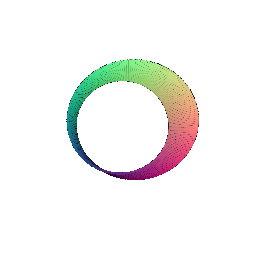

In [33]:
try:
    from IPython.display import Image as IPImage, display

    display(IPImage(filename="images/mobius_rotation.gif"))
except Exception as e:
    print("Could not display GIF inline:", e)

In [35]:
import mcubes

In [41]:
# ----------------------------------------------------------------------------
# Helper: Generate an implicit mesh using marching cubes.
def generate_implicit_mesh(
    implicit_func, min_value, max_value, voxel_size=128, isovalue=0
):
    """
    Evaluate an implicit function F(x,y,z) on a voxel grid and extract the 0-level set using marching cubes.
    Returns:
        vertices (torch.Tensor): (N, 3) vertices in world coordinates.
        faces (torch.Tensor): (M, 3) integer indices into vertices.
    """
    # Create a voxel grid.
    lin = torch.linspace(min_value, max_value, voxel_size, device=device)
    X, Y, Z = torch.meshgrid(lin, lin, lin, indexing="ij")
    F = implicit_func(X, Y, Z)
    # Convert to a NumPy array for mcubes.
    F_np = F.detach().cpu().numpy()
    # (Optional) smooth the voxel grid.
    F_np = mcubes.smooth(F_np)
    # Run marching cubes to extract the zero level set.
    vertices, faces = mcubes.marching_cubes(F_np, isovalue)
    vertices = torch.tensor(vertices, dtype=torch.float32, device=device)
    faces = torch.tensor(faces.astype(np.int64), dtype=torch.int64, device=device)
    # The vertices are in voxel coordinates (ranging from 0 to voxel_size-1). Map them to world coordinates.
    vertices = (vertices / (voxel_size - 1)) * (max_value - min_value) + min_value
    return vertices, faces


# ----------------------------------------------------------------------------
# 1. Construct a Torus Mesh via an Implicit Function.
# Standard implicit equation for a torus with major radius R and minor radius r:
#    F(x,y,z) = ((sqrt(x^2+y^2) - R)^2 + z^2 - r^2)
def torus_implicit(X, Y, Z, R=1.0, r=0.3):
    return (torch.sqrt(X**2 + Y**2) - R) ** 2 + Z**2 - r**2


# Set the bounds and resolution.
min_val, max_val = -2.0, 2.0
voxel_size = 128
torus_vertices, torus_faces = generate_implicit_mesh(
    lambda X, Y, Z: torus_implicit(X, Y, Z, R=1.0, r=0.3),
    min_val,
    max_val,
    voxel_size,
    isovalue=0,
)

# Create per-vertex colors (for a simple texture, we can use normalized vertex coordinates).
torus_textures = (torus_vertices - torus_vertices.min()) / (
    torus_vertices.max() - torus_vertices.min()
)
from pytorch3d.renderer import TexturesVertex

torus_textures = TexturesVertex(torus_textures.unsqueeze(0))
torus_mesh = structures.Meshes(
    verts=[torus_vertices], faces=[torus_faces], textures=torus_textures
).to(device)


# -----------------------------
# 2. Define the Implicit Function for a Möbius Strip.
# We define the function:
#   F(x,y,z) = (sqrt(x^2+z^2) - (1 + 0.5*sin(2*theta)))^2 + y^2 - r^2,
# where theta = atan2(z, x) and r=0.1.
def generate_mobius_mesh(num_samples=200, device=device):
    # Sample parameters.
    u = torch.linspace(0, 2 * np.pi, num_samples, device=device)
    v = torch.linspace(-0.5, 0.5, num_samples, device=device)
    U, V = torch.meshgrid(u, v, indexing="ij")

    # Parametric equations for the Möbius strip.
    x = (1 + (V / 2) * torch.cos(U / 2)) * torch.cos(U)
    y = (1 + (V / 2) * torch.cos(U / 2)) * torch.sin(U)
    z = (V / 2) * torch.sin(U / 2)

    # Combine into a (num_samples x num_samples x 3) tensor.
    points = torch.stack([x, y, z], dim=2)  # shape: (num_samples, num_samples, 3)

    # Flatten to get vertices: (num_samples*num_samples, 3)
    vertices = points.reshape(-1, 3)

    # Build faces by connecting adjacent grid points.
    faces = []
    for i in range(num_samples - 1):
        for j in range(num_samples - 1):
            # Compute the vertex indices for the current quad.
            idx0 = i * num_samples + j
            idx1 = idx0 + 1
            idx2 = idx0 + num_samples
            idx3 = idx2 + 1
            # Split quad into two triangles.
            faces.append([idx0, idx2, idx1])
            faces.append([idx1, idx2, idx3])
    faces = torch.tensor(faces, dtype=torch.int64, device=device)

    # Optionally, compute per-vertex colors by normalizing the vertex coordinates.
    colors = (vertices - vertices.min()) / (vertices.max() - vertices.min())

    return vertices, faces, colors


# Example usage:
mobius_vertices, mobius_faces, colors = generate_mobius_mesh(
    num_samples=200, device=device
)

# Create a simple per-vertex color by normalizing vertex coordinates.
mobius_textures = (mobius_vertices - mobius_vertices.min()) / (
    mobius_vertices.max() - mobius_vertices.min()
)
mobius_textures = TexturesVertex(mobius_textures.unsqueeze(0))
mobius_mesh = structures.Meshes(
    verts=[mobius_vertices], faces=[mobius_faces], textures=mobius_textures
).to(device)


# ----------------------------------------------------------------------------
# 3. Define a function to render a mesh from a specified viewpoint.
mesh_renderer = get_mesh_renderer(image_size=256, device=device)


def render_mesh(mesh, distance=4.0, elev=20.0, azim=0.0):
    R, T = look_at_view_transform(dist=distance, elev=elev, azim=azim, device=device)
    cameras = FoVPerspectiveCameras(R=R, T=T, device=device)
    lights = PointLights(location=[[0, 0, -3]], device=device)
    rend = mesh_renderer(mesh, cameras=cameras, lights=lights)
    image = rend[0, ..., :3].cpu().numpy()
    return (255 * image).astype(np.uint8)


# ----------------------------------------------------------------------------
# 4. Create a 360° Rotation GIF for a given mesh.
def create_rotation_gif(
    mesh, gif_path, num_frames=36, distance=4.0, elev=20.0, image_size=256
):
    frames = []
    for az in np.linspace(0, 360, num_frames, endpoint=False):
        img = render_mesh(mesh, distance=distance, elev=elev, azim=az)
        frames.append(img)
    imageio.mimsave(gif_path, frames, duration=1 / 15, loop=0)
    print("Saved GIF to:", gif_path)
    return gif_path


# ----------------------------------------------------------------------------
# 5. Generate and Render the Implicit Torus Mesh.
torus_gif_path = create_rotation_gif(
    torus_mesh,
    gif_path="images/torus_implicit.gif",
    num_frames=36,
    distance=4.0,
    elev=20.0,
    image_size=256,
)

# 6. Generate and Render the mobius mesh (new object).
mobius_gif_path = create_rotation_gif(
    mobius_mesh,
    gif_path="images/mobius_implicit.gif",
    num_frames=36,
    distance=4.0,
    elev=20.0,
    image_size=256,
)

Saved GIF to: images/torus_implicit.gif
Saved GIF to: images/mobius_implicit.gif
